In [8]:
#TODO: Import your dependencies.
#For instance, below are some dependencies you might need if you are using Pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import argparse

In [9]:
import json
import logging
import os
import sys

In [10]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [67]:
def test(model, test_loader, criterion):
    print("Testing Model on Testing Dataset")
    model.eval()
    running_loss=0
    running_corrects=0
    
    running_samples=0
    
    for inputs, labels in test_loader:
        #inputs=inputs.to(device)
        #labels=labels.to(device)
        
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        
        running_samples+=len(inputs)
        
        # Early stopping so that we don't test the whole dataset, especially for hyperparameter tuning
        if running_samples>(0.005*len(test_loader.dataset)):
            break

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects/ len(test_loader.dataset)
    print(f"Testing Accuracy: {100*total_acc}, Testing Loss: {total_loss}")

In [68]:
def train(model, train_loader, validation_loader, criterion, optimizer):
    epochs=2
    best_loss=1e6
    image_dataset={'train':train_loader, 'valid':validation_loader}
    loss_counter=0
    
    for epoch in range(1, epochs+1):
        for phase in ['train', 'valid']:
            print(f"Epoch {epoch}, Phase {phase}")
            if phase=='train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            running_samples=0

            for step, (inputs, labels) in enumerate(image_dataset[phase]):
                #inputs=inputs.to(device)
                #labels=labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                running_samples+=len(inputs)
                if running_samples % 2000  == 0:
                    accuracy = running_corrects/running_samples
                    print("Images [{}/{} ({:.0f}%)] Loss: {:.2f} Accuracy: {}/{} ({:.2f}%)".format(
                            running_samples,
                            len(image_dataset[phase].dataset),
                            100.0 * (running_samples / len(image_dataset[phase].dataset)),
                            loss.item(),
                            running_corrects,
                            running_samples,
                            100.0*accuracy,
                        )
                    )
                
                #NOTE: Comment lines below to train and test on whole dataset
                if running_samples>(0.2*len(image_dataset[phase].dataset)):
                    break

            epoch_loss = running_loss / running_samples
            epoch_acc = running_corrects / running_samples
            
            if phase=='valid':
                if epoch_loss<best_loss:
                    best_loss=epoch_loss
                else:
                    loss_counter+=1

        if loss_counter==1:
            break
    return model

In [61]:
def net():
    '''
    TODO: Complete this function that initializes your model
          Remember to use a pretrained model
    '''
    model = models.resnet50(weights='IMAGENET1K_V2')

    for param in model.parameters():
        param.requires_grad = False   

    num_features=model.fc.in_features
    model.fc = nn.Sequential(
                   nn.Linear(num_features, 133))
    return model

In [62]:
def create_data_loaders(data, batch_size):
    '''
    This is an optional function that you may or may not need to implement
    depending on whether you need to use data loaders or not
    '''
    train_data_path = os.path.join(data, 'train')
    test_data_path = os.path.join(data, 'test')
    validation_data_path=os.path.join(data, 'valid')
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ]
    )
    train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
    
    test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)
    
    validation_data = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
    validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,shuffle=True)
    
    return train_data_loader,test_data_loader,validation_data_loader

In [63]:
# Could be needed, from live class
# instead of inference script, like in examples
def model_fn(model_dir):
    model = Net()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    return model

In [73]:
def save_model(model, model_dir):
    logger.info("Saving the model.")
    path = os.path.join(model_dir, "model.pth")
    torch.save(model.cpu().state_dict(), path)

In [74]:
def main(args):
    '''
    TODO: Initialize a model by calling the net function
    '''
    model=net()
    
    '''
    TODO: Create your loss and optimizer
    '''
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
                          model.fc.parameters(), 
                          lr=args.learning_rate
                          )
    
    '''
    TODO: Call the train function to start training your model
    Remember that you will need to set up a way to get training data from S3
    '''
    train_data_loader, test_data_loader, validation_data_loader=create_data_loaders(args.data, args.batch_size)
    
    model=train(model, train_data_loader, validation_data_loader, loss_criterion, optimizer)
    
    '''
    TODO: Test the model to see its accuracy
    '''
    test(model, test_data_loader, loss_criterion)
    
    '''
    TODO: Save the trained model
    '''
    save_model(model, args.model_dir)

In [70]:
if __name__=='__main__':
    parser=argparse.ArgumentParser()
    '''
    TODO: Specify all the hyperparameters you need to use to train your model.
    '''
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    
    parser.add_argument(
        "--lr", type=float, default=1.0, metavar="LR", help="learning rate (default 1.0)"
    )
    
    parser.add_argument('--data', type=str, default=os.environ['SM_CHANNEL_TRAINING']) 
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--output_dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    
    args=parser.parse_args()
    
    main(args)

KeyError: 'SM_CHANNEL_TRAINING'

# Test - do not copy back to hpo.py

In [19]:
import sys
import os

## Arguments

In [20]:
sys.argv

['/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py',
 '-f',
 '/root/.local/share/jupyter/runtime/kernel-39d5b8c5-ff61-4086-b312-4f6505787758.json']

In [21]:
# From script_mode.ipynb example

In [22]:
sys.argv = ["hpy.py", "--batch-size","32","--lr","0.001"]

In [23]:
os.environ["SM_MODEL_DIR"] = "/opt/ml/model"
os.environ["SM_CHANNNEL_TEST"] = "./dogImages/test"
os.environ["SM_CHANNNEL_TRAINING"] = "./dogImages/train"
os.environ["SM_CHANNNEL_VALID"] = "./dogImages/valid"

In [24]:
#estimator.fit({"train": "s3://my-bucket/data/train", "valid": "/..."

In [25]:
sudo mkdir /opt/ml/model
#!sudo chown -R ec2-user:ec2-user /opt/ml/model

/usr/bin/sh: 1: sudo: not found
/usr/bin/sh: 1: sudo: not found


In [26]:
# In sagemaker studio terminal
sudo chown -R sagemaker-user:users /opt/ml/model

SyntaxError: invalid syntax (<ipython-input-26-7baa0023169e>, line 2)

## Data Loaders

In [30]:
import matplotlib.pyplot as plt

In [31]:
%matplotlib inline

In [39]:
train_data_loader, test_data_loader, validation_data_loader = create_data_loaders("./dogImages", 32)

In [40]:
for batch in train_data_loader:
    break

[2023-02-21 20:36:34.109 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:66 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-21 20:36:35.226 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:66 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [41]:
type(batch)

list

In [42]:
len(batch)

2

In [43]:
batch[0].shape # 32 images, 3 colors, 224x224

torch.Size([32, 3, 224, 224])

In [44]:
batch[0][0] # Single image

tensor([[[0.0510, 0.0549, 0.0431,  ..., 0.1569, 0.1725, 0.1882],
         [0.0745, 0.0667, 0.0706,  ..., 0.1451, 0.1725, 0.1882],
         [0.0627, 0.0706, 0.0941,  ..., 0.1294, 0.1725, 0.2000],
         ...,
         [0.0667, 0.0745, 0.0627,  ..., 0.1686, 0.1843, 0.1765],
         [0.0588, 0.0706, 0.0627,  ..., 0.2039, 0.1961, 0.1725],
         [0.0667, 0.0549, 0.0392,  ..., 0.1882, 0.1608, 0.1608]],

        [[0.2667, 0.2627, 0.2549,  ..., 0.4824, 0.5020, 0.5216],
         [0.2824, 0.2706, 0.2863,  ..., 0.4667, 0.5059, 0.5333],
         [0.2706, 0.2863, 0.3216,  ..., 0.4549, 0.5020, 0.5412],
         ...,
         [0.2824, 0.2627, 0.2431,  ..., 0.4941, 0.5137, 0.5098],
         [0.2627, 0.2588, 0.2471,  ..., 0.5412, 0.5294, 0.5059],
         [0.2588, 0.2235, 0.1843,  ..., 0.5255, 0.4902, 0.4902]],

        [[0.3882, 0.3843, 0.3765,  ..., 0.6431, 0.6588, 0.6745],
         [0.4118, 0.4000, 0.4196,  ..., 0.6275, 0.6588, 0.6824],
         [0.3922, 0.4196, 0.4627,  ..., 0.6118, 0.6549, 0.

In [45]:
batch[0][0].shape

torch.Size([3, 224, 224])

In [46]:
batch[0][0].permute(1,2,0).shape

torch.Size([224, 224, 3])

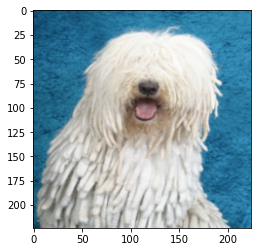

In [47]:
plt.imshow(batch[0][0].permute(1,2,0))

In [48]:
batch[1][0]

tensor(93)

In [49]:
# Go to /train/036... -> this dog class

## Model

In [50]:
model = net()

In [51]:
type(model)

torchvision.models.resnet.ResNet

In [52]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
learning_rate = 0.001

In [57]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
                      model.fc.parameters(), 
                      lr=learning_rate
                      )

In [69]:
model=train(model, train_data_loader, validation_data_loader, loss_criterion, optimizer)

Epoch 1, Phase train
Epoch 1, Phase valid
Epoch 2, Phase train
Epoch 2, Phase valid


In [72]:
test(model, test_data_loader, loss_criterion)

Testing Model on Whole Testing Dataset
Testing Accuracy: 1.674641148325359, Testing Loss: 0.1029548462498131


In [76]:
save_model(model, "./trained_model")

Saving the model.
Saving the model.


INFO:__main__:Saving the model.
